In [1]:
using MAT, Statistics, LinearAlgebra,Random, Plots, NonlinearSolve
using StaticArrays, Distributed, SciMLNLSolve, LineSearches
include("mvnrnd.jl")

mvnrnd (generic function with 1 method)

In [2]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    if size(v,2) == 1 # check if v is a column vector
        @eval (($s) = (vec($v)))
    else
        @eval (($s) = ($v))
    end
end

file = matopen("simulationData.mat")

#Reads in ju[IO, price, Omega, data, labor, mu, aggtfp, alpha, grossy, stfp, beta, agggdp, Sigma, capital, vadd]

varnames = names(file)
for varname in varnames
    val = read(file, varname)
    # Instantiate the variable with its name in the current scope
    string_as_varname(varname,val)
    end

close(file)



In [3]:
function getVariables(year)
    IO = data[data[:,1] .== year,:]
    temp = [8,60,62,80:88...]
    IO = IO[setdiff(1:end,temp),setdiff(1:end,[1,2,3,4,5,94])]
    IO = IO[:,setdiff(1:end,temp)]
    Ω = IO ./ sum(IO,dims=2)
    α = vadd[:,year-1959] ./ grossy[:,year-1959];
    β = (grossy[:,year-1959]' * (I-diagm(1 .- α)*Ω))';
    β[beta .< 0] .= 0
    β = β / sum(β)
    λ = (inv(I - diagm(1 .- alpha)*Ω)' * β);
    L = λ .* α
    
    return α,β,Ω,L,λ

end

getVariables (generic function with 1 method)

In [4]:
domar_weights = (inv(I - diagm(1 .- alpha) * Omega)' * beta);
L = domar_weights .* alpha;

In [5]:
ε = .5;
θ = 0.001;
σ = .9;

In [6]:
function problem(X :: AbstractVector{T}, A, β, Ω, α, ε, θ, σ,L) where T



    N = length(α)
    p = X[1:N]
    y = X[N+1:end]
    
    Out :: Vector{T} = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    Out[1:N] = p - (A .^ (ε - 1) .* (α .* w .^ (1- ε) + (1 .- α) .* q .^ (1 - ε))) .^ (1/(1-ε))
    Out[N+1:end] = y' - y' * diagm(p)^ε * diagm(A)^(ε-1) * diagm(q)^(θ-ε) * diagm(1 .- α) * Ω * diagm(p)^(-θ) - β'*diagm(p)^(-σ)*C
    
    return Out
end

problem (generic function with 1 method)

In [7]:
function problemJacobian(X, A, β, Ω, α, ε, θ, σ,L)
    N = length(α)
    p = @view X[1:N]
    y = @view X[N+1:end]
    
    Out = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    
    DQDP = (q .^ θ * (p.^(-θ))') .* Ω;
    DWDP = diagm(A.^((ε-1)/ε) .* α.^(1/ε) .* y.^(1/ε) .* (1 ./ L).^(1/ε));
    DWDY = (1/ε) * diagm(p .* A.^((ε-1)/ε) .* α.^(1/ε).* (y.^(1/ε-1)) .* L.^(-1/ε));
    DCDP = DWDP' * L; 
    DCDY = DWDY' * L;

    DOut1DP = I - diagm(diagm(A)^(-1) * ((α .* (w .^ (1-ε)) + (1 .- α) .* (q.^(1-ε)))).^(ε/(1-ε))) * (diagm(α) * diagm(w.^(-ε))* DWDP + diagm(1 .-α)*diagm(q.^(-ε))*DQDP);

    DOut1DY =  -diagm(diagm(A.^(-1))*((α.*(w.^(1-ε))+(1 .- α).*(q.^(1-ε)))).^(ε/(1-ε)))*(diagm(α)*diagm(w.^(-ε))*DWDY);

    DOut2DP = -(ε * diagm(p.^(-θ))*Ω'*diagm((p.^(ε-1)).*(y).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))
        + (θ-ε)*diagm(p.^(-θ))*Ω'*diagm((p.^(ε)).*(y).*(q.^(θ-ε-1)).*(1 .- α).*(A.^(ε-1)))*DQDP 
        - σ*diagm(β.*p.^(-σ-1))*C + broadcast(*, β.*(p.^(-σ)), DCDP')
        - θ* diagm(p.^(-θ-1)).*diagm(Ω'*diagm((p.^(ε)).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))*y));

    DOut2DY = I - (diagm(p)^ε*diagm(A)^(ε-1)*diagm(q)^(θ-ε)*diagm(1 .- α)*Ω*diagm(p)^(-θ))' - broadcast(*, β.*(p.^(-σ)), DCDY');
    OutDeriv = [DOut1DP DOut1DY; DOut2DP DOut2DY];

end

problemJacobian (generic function with 1 method)

In [8]:
trials = 50;
GDP = zeros(trials)
λ = zeros(76,trials)

function f!(F,u,p)
    F[1:152] = problem(u,p,beta,Omega,alpha,ε,θ,σ,L)
end

function j!(J,u,p)
    J[1:152,1:152] = problemJacobian(u,p,beta,Omega,alpha,ε,θ,σ,L)
end

f = NonlinearFunction(f!)

Threads.@threads for k in 1:trials
    
        
    A = exp.(mvnrnd(-1/2*diag(Sigma),diagm(diag(Sigma))));
    
    init = [Complex.(exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A)))..., Complex.(domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A)))...];
    
    #init = [exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A))..., (domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A)))...]


    p = A

    ProbN = NonlinearProblem(f,init,p)
    sol = solve(ProbN,NLSolveJL(linesearch = HagerZhang(),method = :newton), reltol = 1e-8,abstol = 1e-8)

    x = sol.u
    println("solv")

    GDP[k] = (x[1:76] .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(x[77:152].^(1/ε)).* L .^ (-1/ε))' * L;
    λ[:,k] = (x[1:76] .* x[77:end]) / GDP[k] 


        
end

TaskFailedException: TaskFailedException

    nested task error: UndefVarError: Sigma not defined
    Stacktrace:
     [1] macro expansion
       @ ~/Schreibtisch/BeyondHulten/Translation/OtherSolver.ipynb:18 [inlined]
     [2] (::var"#67#threadsfor_fun#10"{var"#67#threadsfor_fun#9#11"{UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ Main ./threadingconstructs.jl:84
     [3] #67#threadsfor_fun
       @ ./threadingconstructs.jl:51 [inlined]
     [4] (::Base.Threads.var"#1#2"{var"#67#threadsfor_fun#10"{var"#67#threadsfor_fun#9#11"{UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:30

In [8]:
function shockSectorProgressively(sector,shocks,x0,year = 1983)

    (α,β,Ω,L,λ) = getVariables(year);
    f = NonlinearFunction((u,p) -> problem(u,p...),jac = (u,p) -> problemJacobian(u,p...))
    GDP = []
    for shock in shocks
        A  = ones(76)
        A[sector] = shock
        
        
    
    
        p = [A,β,Ω,α,ε,θ,σ,L]
        ProbN = NonlinearProblem(f,x0,p)
        
        #sol = solve(ProbN,NewtonRaphson(), reltol = 1e-10,abstol = 1e-8)
        sol = solve(ProbN,NLSolveJL(method = :newton, linesearch = BackTracking()), reltol = 1e-10,abstol = 1e-8)

        x = sol.u
        
        p = real.(x[1:76]) 
        y = real.(x[77:152])
        append!(GDP, (p .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(y.^(1/ε)).* L .^ (-1/ε))' * L)


        x0 =  x
    end

    return GDP

end

shockSectorProgressively (generic function with 2 methods)

In [15]:
year = 1985
M = 400

a = 0.7;
b = 1.3;

(α, β, Ω, L, λ) = getVariables(year);

sectors = [8, 9, 10]

GDP = zeros(2 * M, length(sectors))


for i in 1:length(sectors)

    x0 = Complex.([ones(76)..., λ...])

    GDP[1:M, i] = shockSectorProgressively(sectors[i], LinRange(1, a, M), x0, year)
    GDP[M+1:end, i] = shockSectorProgressively(sectors[i], LinRange(1, b, M), x0, year)


end

In [13]:

@views reverse!(GDP[1:M,:],dims=1)
GDP = GDP[setdiff(1:end,M),:]

79×3 Matrix{Float64}:
 0.991116  0.990879  0.964711
 0.990172  0.99086   0.964649
 0.993148  0.990841  0.968208
 0.992253  0.990822  0.968145
 0.992774  0.990803  0.968083
 0.992741  0.990785  0.97216
 0.992028  0.990766  0.972099
 0.991943  0.990748  0.97204
 0.992326  0.990731  0.973694
 0.991499  0.990713  0.973638
 ⋮                   
 0.966625  0.977248  0.977099
 0.966315  0.977219  0.976913
 0.966013  0.976613  0.976711
 0.96572   0.976586  0.976569
 0.965434  0.97656   0.976547
 0.965117  0.976534  0.976523
 0.964843  0.976509  0.9765
 0.964592  0.976461  0.976283
 0.964355  0.976269  0.975469

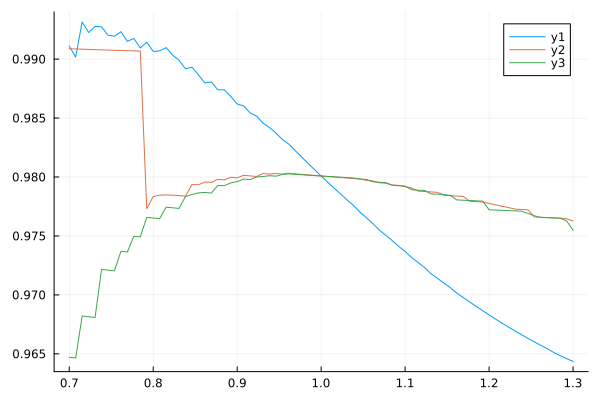

In [14]:
plot(LinRange(a,b,2*M-1),GDP[:,1])
plot!(LinRange(a,b,2*M-1),GDP[:,2])
plot!(LinRange(a,b,2*M-1),GDP[:,3])

In [15]:
GDP

19×3 Matrix{Float64}:
 3.3907    4.9875   1.01261
 0.99162   2.71701  1.01394
 0.992212  1.00974  1.01198
 0.993508  1.00788  1.01086
 0.9967    1.00619  1.00971
 1.00181   1.00928  1.00905
 1.00388   1.00965  1.0093
 1.00875   1.01141  1.00807
 1.00992   1.01204  1.01142
 1.00961   1.00961  1.00961
 1.0092    1.00792  1.00835
 1.0098    1.0086   1.00747
 1.00924   1.00683  1.00664
 1.00981   1.0063   1.00497
 1.00934   1.00562  1.00439
 1.00891   1.00501  1.00291
 1.00876   1.00459  1.0015
 1.00839   1.00286  1.00017
 1.00826   1.00359  0.999687